In [1]:
from __future__ import print_function, division
import mdtraj as md
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from mdtraj.geometry import _geometry
import os
import sys
import numpy as np
import scipy 
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
from mdtraj.geometry import _geometry
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from scipy.stats import pearsonr
import pickle
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import deeptime
from deeptime.decomposition import TICA
import pyemma
from deeptime.clustering import KMeans

In [3]:
!pwd

/data/asn/tica/lig_47/combined


In [4]:
d = {i:np.arange(10) for i in range(10)}

In [5]:
import pandas
df = pandas.DataFrame(d)

In [4]:
traj_dir='/data/asn/tica/lig47/combined/'
pdb = '/data/asn/biorxiv2021-6626290-no-water-glue/lig47.pdb'
rep0 = '/data/asn/biorxiv2021-6626290-no-water-glue/ligand_47_1.xtc'
dtraj= np.load('/data/asn/tica/lig_47/combined/dtraj_pca_combined_feature_lig_47.npy')

traj = md.load(rep0, top=pdb)
#trj.center_coordinates()
#top = trj.topology

k = 4
frames_cl = [np.where(dtraj==i)[0] for i in range(k)]
    
xtc=[]
trj={}
top={}
for i in range(0,k):
    #xtc=traj_dir+"fusadil_cluster8_"+str(i)+'_d4.dcd'

    trj[i] = traj[frames_cl[i]]
    trj[i].center_coordinates()
    top[i] = trj[i].topology

    print(trj[i].n_frames)#,trj[1].unitcell_lengths[0][0])

#n_frames=trj.n_frames
box_len=trj[1].unitcell_lengths[0][0]
top=trj[1].topology
print(top)

216423
325699
355216
203551
<mdtraj.Topology with 1 chains, 22 residues, 338 atoms, 296 bonds>


In [7]:
frames_cl[0]

array([ 178205,  178206,  178207, ...,  988597,  988608, 1006313])

In [8]:
dtraj.shape

(1100889,)

In [9]:
traj.n_frames

1100889

pdb = '/data/asn/biorxiv2021-6626290-no-water-glue/lig47.pdb'
rep0 = '/data/asn/tica/lig_47/dist/lig47_cluster8_1.dcd'
traj = md.load(rep0, top=pdb)

In [5]:
# Define Aromatic Rings
ligand_rings=[[307,308,309,311,313,314]]

# Definie Hydrogen Bond Donors
lig_hbond_donors=[[329,331],[329,330]]

#Select Ligand Charge Groups
#Ligand Charged atom is N-296
Ligand_Pos_Charges=[329]
Ligand_Neg_Charges=[]

residues = 21
residue_offset = 121
residue_number = range(0, residues)
residue_number_offset = range(residue_offset, residue_offset+residues)

In [6]:
# block function from pyblock package -  https://github.com/jsspencer/pyblock
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances
    # for each blocking transformation
    for i in arange(0, d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum((x[0:(n-1)]-mu)*(x[1:n]-mu))
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]

    # we need a list of magic numbers
    q = array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0, d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))


def free_energy_1D_blockerror(a, T, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(histo)
    # free_energy=-(0.001987*T)*np.log(histo)
    free_energy = -(0.001987*T)*np.log(histo+.000001)
    free_energy = free_energy-np.min(free_energy)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    ferr = -(0.001987*T)*(error / average)
    return free_energy, xcenters, ferr


def chunkIt(a, num):
    avg = a / float(num)
    out = []
    last = 0.0
    while last < a-1:
        out.append([int(last), int(last+avg)])
        last += avg
    return out


def histo_blockerror(a, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    return average, xcenters, error


def Kd_calc(bound, conc):
    return((1-bound)*conc/bound)


def get_blockerrors(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        be = block(data)**.5
        ave.append(np.average(data))
        block_errors.append(be)
    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac

    return ave_bf, be_bf


def get_blockerrors_pyblock(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        if (average != 0) and (average != 1):
            reblock_data = pyblock.blocking.reblock(data)
            opt = pyblock.blocking.find_optimal_block(
                len(data), reblock_data)[0]
            opt_block = reblock_data[opt]
            be = opt_block[4]
        else:
            be = 0
        ave.append(average)
        block_errors.append(be)

    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac
    return ave_bf, be_bf


def get_blockerror(Data):
    data = Data
    average = np.average(data)
    be = block(data)**.5
    return average, be


def get_blockerror_pyblock(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)


def get_blockerror_pyblock_nanskip(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        if(math.isnan(opt)):
            be_max = 0
            for i in range(0, len(reblock_data)):
                be = reblock_data[i][4]
                if(be > be_max):
                    be_max = be
        else:
            be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)

def get_blockerrors_pyblock_nanskip(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        if (average != 0) and (average != 1):
            reblock_data = pyblock.blocking.reblock(data)
            opt = pyblock.blocking.find_optimal_block(len(data), reblock_data)[0]
 #           opt_block = reblock_data[opt]
 #           be = opt_block[4]
            if (math.isnan(opt)):
                be_max=0
                for i in range(0, len(reblock_data)):
                    be = reblock_data[i][4]
                    if (be > be_max) :
                        be_max=be
            else:
                be = reblock_data[opt][4]
            
        else:
            be = 0
        ave.append(average)
        block_errors.append(be)

    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac
    return ave_bf, be_bf

def get_blockerror_pyblock_max(Data):
    average=np.average(Data)
    if (average!=0) and (average!=1):
        reblock_data = pyblock.blocking.reblock(Data)
        be_max=0
        for i in range(0,len(reblock_data)): 
            be=reblock_data[i][4]
            if(be > be_max):
                be_max=be
    else:
        be=0
    return average,float(be)

def calc_SA(trj, helix, start, stop):
    r0 = .10
    RMS_start = start
    RMS_stop = stop
    RMS = []
    for i in range(RMS_start, RMS_stop):
        sel = helix.topology.select("residue %s to %s and name CA" % (i, i+6))
        rmsd = md.rmsd(trj, helix, atom_indices=sel)
        RMS.append(rmsd)
    RMS = np.asarray(RMS)
    Sa_sum = np.zeros((trj.n_frames))
    Sa = (1.0-(RMS/0.10)**8)/(1-(RMS/0.10)**12)
    return Sa


def calc_Rg(trj):
    mass = []
    for at in trj.topology.atoms:
        mass.append(at.element.mass)
    mass_CA = len(mass)*[0.0]
    for i in trj.topology.select("name CA"):
        mass_CA[i] = 1.0
    rg_CA = md.compute_rg(trj, masses=np.array(mass_CA))
    return rg_CA


def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


def free_energy_reweight(a, b, T, y0, ymax, x0, xmax, weight):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=weight)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


def free_energy_1D_noscale(a, T, x0, xmax, bins):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    free_energy = np.log(free_energy+.000001)
    free_energy = -(0.001987*T)*free_energy
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def free_energy_1D(a, T, x0, xmax, bins):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(free_energy)
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*(free_energy-np.log(max+.0000001))
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def free_energy_1D_reweight(a, T, x0, xmax, bins, weight):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=weight)
    max = np.max(free_energy)
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*(free_energy-np.log(max+.0000001))
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def alphabeta_rmsd(phi, psi, phi_ref, psi_ref):
    alphabetarmsd = np.sum(0.5*(1+np.cos(psi-psi_ref)),
                           axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)), axis=1)
    return alphabetarmsd


def dssp_convert(dssp):
    dsspH = np.copy(dssp)
    dsspE = np.copy(dssp)
    dsspH[dsspH == 'H'] = 1
    dsspH[dsspH == 'E'] = 0
    dsspH[dsspH == 'C'] = 0
    dsspH[dsspH == 'NA'] = 0
    dsspH = dsspH.astype(int)
    TotalH = np.sum(dsspH, axis=1)
    SE_H = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspH[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_H[i] = [np.mean(data), (block(data))**.5]

    dsspE[dsspE == 'H'] = 0
    dsspE[dsspE == 'E'] = 1
    dsspE[dsspE == 'C'] = 0
    dsspE[dsspE == 'NA'] = 0
    dsspE = dsspE.astype(int)
    TotalE = np.sum(dsspE, axis=1)
    Eprop = np.sum(dsspE, axis=0).astype(float)/len(dsspE)
    SE_E = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspE[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_E[i] = [np.mean(data), (block(data))**.5]
    return SE_H, SE_E


def calc_phipsi(trj):
    indices_phi, phis = md.compute_phi(trj)
    indices_psi, psis = md.compute_psi(trj)
    phi_label = []
    for i_phi in range(0, indices_phi.shape[0]):
        resindex = trj.topology.atom(indices_phi[i_phi][2]).residue.resSeq
        phi_label.append(resindex)
    phi_label = np.array(phi_label)
    psi_label = []
    for i_psi in range(0, indices_psi.shape[0]):
        resindex = trj.topology.atom(indices_psi[i_psi][2]).residue.resSeq
        psi_label.append(resindex)
    psi_label = np.array(psi_label)
    phipsi = []
    for i in range(0, len(phi_label)-1):
        current_phipsi = np.column_stack((phis[:, i+1], psis[:, i]))
        phipsi.append(current_phipsi)
    phipsi_array = np.array(phipsi)
    return(phipsi_array, psi_label, phi_label)

# Functions to Calculate Aromatic Stacking Interactions

def find_plane_normal(points):

    N = points.shape[0]
    A = np.concatenate((points[:, 0:2], np.ones((N, 1))), axis=1)
    B = points[:, 2]
    out = lstsq(A, B, rcond=-1)
    na_c, nb_c, d_c = out[0]
    if d_c != 0.0:
        cu = 1./d_c
        bu = -nb_c*cu
        au = -na_c*cu
    else:
        cu = 1.0
        bu = -nb_c
        au = -na_c
    normal = np.asarray([au, bu, cu])
    normal /= math.sqrt(dot(normal, normal))
    return normal


def find_plane_normal2(positions):
    # Alternate approach used to check sign - could the sign check cause descrepency with desres?
    # Use Ligand IDs 312, 308 and 309 to check direction
    # [304 305 306 307 308 309 310 311 312 313]
    v1 = positions[0]-positions[1]
    v1 /= np.sqrt(np.sum(v1**2))
    v2 = positions[2]-positions[1]
    v2 /= np.sqrt(np.sum(v2**2))
    normal = np.cross(v1, v2)
    return normal


def find_plane_normal2_assign_atomid(positions, id1, id2, id3):
    # Alternate approach used to check sign - could the sign check cause descrepency with desres?
    v1 = positions[id1]-positions[id2]
    v1 /= np.sqrt(np.sum(v1**2))
    v2 = positions[id3]-positions[id1]
    v2 /= np.sqrt(np.sum(v2**2))
    normal = np.cross(v1, v2)
    return normal


def get_ring_center_normal_assign_atomid(positions, id1, id2, id3):
    center = np.mean(positions, axis=0)
    normal = find_plane_normal(positions)
    normal2 = find_plane_normal2_assign_atomid(positions, id1, id2, id3)
    # check direction of normal using dot product convention
    comp = np.dot(normal, normal2)
    if comp < 0:
        normal = -normal
    return center, normal


def get_ring_center_normal_(positions):
    center = np.mean(positions, axis=0)
    normal = find_plane_normal(positions)
    normal2 = find_plane_normal2(positions)
    # check direction of normal using dot product convention
    comp = np.dot(normal, normal2)
    if comp < 0:
        normal = -normal
    return center, normal


def angle(v1, v2):
    return np.arccos(np.dot(v1, v2)/(np.sqrt(np.dot(v1, v1))*np.sqrt(np.dot(v2, v2))))


def get_ring_center_normal_trj_assign_atomid(position_array, id1, id2, id3):
    length = len(position_array)
    centers = np.zeros((length, 3))
    normals = np.zeros((length, 3))
    centers_normals = np.zeros((length, 2, 3))
    print(np.shape(length), np.shape(centers), np.shape(normals))
    for i in range(0, len(position_array)):
        center, normal = get_ring_center_normal_assign_atomid(
            position_array[i], id1, id2, id3)
        centers_normals[i][0] = center
        centers_normals[i][1] = normal
    return centers_normals

# MDtraj Functions to Calculate Hydrogen Bonds with custom selections of donors and acceptors

def _get_bond_triplets_print(topology, lig_donors, exclude_water=True, sidechain_only=False):
    def can_participate(atom):
        # Filter waters
        if exclude_water and atom.residue.is_water:
            return False
        # Filter non-sidechain atoms
        if sidechain_only and not atom.is_sidechain:
            return False
        # Otherwise, accept it
        return True

    def get_donors(e0, e1):
        # Find all matching bonds
        # print("get_donors e0 e1:",e0,e1)
        elems = set((e0, e1))
        atoms = [(one, two) for one, two in topology.bonds
                 if set((one.element.symbol, two.element.symbol)) == elems]
        # Filter non-participating atoms
        atoms = [atom for atom in atoms
                 if can_participate(atom[0]) and can_participate(atom[1])]
        # Get indices for the remaining atoms
        indices = []
        for a0, a1 in atoms:
            pair = (a0.index, a1.index)
            # make sure to get the pair in the right order, so that the index
            # for e0 comes before e1
            if a0.element.symbol == e1:
                pair = pair[::-1]
            indices.append(pair)

        return indices

    # Check that there are bonds in topology
    nbonds = 0
    for _bond in topology.bonds:
        nbonds += 1
        break  # Only need to find one hit for this check (not robust)
    if nbonds == 0:
        raise ValueError('No bonds found in topology. Try using '
                         'traj._topology.create_standard_bonds() to create bonds '
                         'using our PDB standard bond definitions.')

    nh_donors = get_donors('N', 'H')
    print("nh_donors", nh_donors)
    for i in nh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    oh_donors = get_donors('O', 'H')
    print("oh_donors", oh_donors)
    for i in oh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    sh_donors = get_donors('S', 'H')
    print("sh_donors", sh_donors)
    for i in sh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    for i in lig_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    # ADD IN ADDITIONAL SPECIFIED LIGAND DONORS
    xh_donors = np.array(nh_donors + oh_donors + sh_donors+lig_donors)

    if len(xh_donors) == 0:
        # if there are no hydrogens or protein in the trajectory, we get
        # no possible pairs and return nothing
        return np.zeros((0, 3), dtype=int)

    acceptor_elements = frozenset(('O', 'N', 'S'))
    acceptors = [a.index for a in topology.atoms
                 if a.element.symbol in acceptor_elements and can_participate(a)]
    print("acceptors")
    for i in acceptors:
        print(top.atom(i))
    # Make acceptors a 2-D numpy array
    acceptors = np.array(acceptors)[:, np.newaxis]

    # Generate the cartesian product of the donors and acceptors
    xh_donors_repeated = np.repeat(xh_donors, acceptors.shape[0], axis=0)
    acceptors_tiled = np.tile(acceptors, (xh_donors.shape[0], 1))
    bond_triplets = np.hstack((xh_donors_repeated, acceptors_tiled))

    # Filter out self-bonds
    self_bond_mask = (bond_triplets[:, 0] == bond_triplets[:, 2])
    return bond_triplets[np.logical_not(self_bond_mask), :]


def _get_bond_triplets(topology, lig_donors, exclude_water=True, sidechain_only=False):
    def can_participate(atom):
        # Filter waters
        if exclude_water and atom.residue.is_water:
            return False
        # Filter non-sidechain atoms
        if sidechain_only and not atom.is_sidechain:
            return False
        # Otherwise, accept it
        return True

    def get_donors(e0, e1):
        # Find all matching bonds
        elems = set((e0, e1))
        atoms = [(one, two) for one, two in topology.bonds
                 if set((one.element.symbol, two.element.symbol)) == elems]
        # Filter non-participating atoms
        atoms = [atom for atom in atoms
                 if can_participate(atom[0]) and can_participate(atom[1])]
        # Get indices for the remaining atoms
        indices = []
        for a0, a1 in atoms:
            pair = (a0.index, a1.index)
            # make sure to get the pair in the right order, so that the index
            # for e0 comes before e1
            if a0.element.symbol == e1:
                pair = pair[::-1]
            indices.append(pair)

        return indices

    # Check that there are bonds in topology
    nbonds = 0
    for _bond in topology.bonds:
        nbonds += 1
        break  # Only need to find one hit for this check (not robust)
    if nbonds == 0:
        raise ValueError('No bonds found in topology. Try using '
                         'traj._topology.create_standard_bonds() to create bonds '
                         'using our PDB standard bond definitions.')

    nh_donors = get_donors('N', 'H')
    oh_donors = get_donors('O', 'H')
    sh_donors = get_donors('S', 'H')
    xh_donors = np.array(nh_donors + oh_donors + sh_donors+lig_donors)

    if len(xh_donors) == 0:
        # if there are no hydrogens or protein in the trajectory, we get
        # no possible pairs and return nothing
        return np.zeros((0, 3), dtype=int)

    acceptor_elements = frozenset(('O', 'N', 'S'))
    acceptors = [a.index for a in topology.atoms
                 if a.element.symbol in acceptor_elements and can_participate(a)]
    # Make acceptors a 2-D numpy array
    acceptors = np.array(acceptors)[:, np.newaxis]

    # Generate the cartesian product of the donors and acceptors
    xh_donors_repeated = np.repeat(xh_donors, acceptors.shape[0], axis=0)
    acceptors_tiled = np.tile(acceptors, (xh_donors.shape[0], 1))
    bond_triplets = np.hstack((xh_donors_repeated, acceptors_tiled))

    # Filter out self-bonds
    self_bond_mask = (bond_triplets[:, 0] == bond_triplets[:, 2])
    return bond_triplets[np.logical_not(self_bond_mask), :]


def _compute_bounded_geometry(traj, triplets, distance_cutoff, distance_indices,
                              angle_indices, freq=0.0, periodic=True):
    """
    Returns a tuple include (1) the mask for triplets that fulfill the distance
    criteria frequently enough, (2) the actual distances calculated, and (3) the
    angles between the triplets specified by angle_indices.
    """
    # First we calculate the requested distances
    distances = md.compute_distances(
        traj, triplets[:, distance_indices], periodic=periodic)

    # Now we discover which triplets meet the distance cutoff often enough
    prevalence = np.mean(distances < distance_cutoff, axis=0)
    mask = prevalence > freq

    # Update data structures to ignore anything that isn't possible anymore
    triplets = triplets.compress(mask, axis=0)
    distances = distances.compress(mask, axis=1)

    # Calculate angles using the law of cosines
    abc_pairs = zip(angle_indices, angle_indices[1:] + angle_indices[:1])
    abc_distances = []

    # Calculate distances (if necessary)
    for abc_pair in abc_pairs:
        if set(abc_pair) == set(distance_indices):
            abc_distances.append(distances)
        else:
            abc_distances.append(md.compute_distances(traj, triplets[:, abc_pair],
                                                      periodic=periodic))

    # Law of cosines calculation
    a, b, c = abc_distances
    cosines = (a ** 2 + b ** 2 - c ** 2) / (2 * a * b)
    np.clip(cosines, -1, 1, out=cosines)  # avoid NaN error
    angles = np.arccos(cosines)
    return mask, distances, angles


def baker_hubbard2(traj, freq=0.1, exclude_water=True, periodic=True, sidechain_only=False,
                   distance_cutoff=0.35, angle_cutoff=150, lig_donor_index=[]):

    angle_cutoff = np.radians(angle_cutoff)

    if traj.topology is None:
        raise ValueError('baker_hubbard requires that traj contain topology '
                         'information')

    # Get the possible donor-hydrogen...acceptor triplets

    # ADD IN LIGAND HBOND DONORS
    add_donors = lig_donor_index

    bond_triplets = _get_bond_triplets(traj.topology,
                                       exclude_water=exclude_water, lig_donors=add_donors, sidechain_only=sidechain_only)

    mask, distances, angles = _compute_bounded_geometry(traj, bond_triplets,
                                                        distance_cutoff, [1, 2], [0, 1, 2], freq=freq, periodic=periodic)

    # Find triplets that meet the criteria
    presence = np.logical_and(
        distances < distance_cutoff, angles > angle_cutoff)
    mask[mask] = np.mean(presence, axis=0) > freq
    return bond_triplets.compress(mask, axis=0)


def print_donors_acceptors(traj, freq=0.1, exclude_water=True, periodic=True, sidechain_only=False,
                           distance_cutoff=0.35, angle_cutoff=150, lig_donor_index=[]):

    angle_cutoff = np.radians(angle_cutoff)

    if traj.topology is None:
        raise ValueError('baker_hubbard requires that traj contain topology '
                         'information')

    # Get the possible donor-hydrogen...acceptor triplets

    # ADD IN LIGAND HBOND DONORS
    # add_donors=[[296,318],[296,331]]
    # Manually tell it where to find proton donors on ligand
    # LIG58-O5 LIG58-H24
    # LIG58-O1 LIG58-H12
    # LIG58-N LIG58-H15
    # add_donors=[[768,796],[750,784],[752,787]]
    add_donors = lig_donor_index

    bond_triplets_print = _get_bond_triplets_print(traj.topology,
                                                   exclude_water=exclude_water, lig_donors=add_donors, sidechain_only=sidechain_only)

    # mask, distances, angles = _compute_bounded_geometry(traj, bond_triplets,
    #    distance_cutoff, [1, 2], [0, 1, 2], freq=freq, periodic=periodic)

    # Find triplets that meet the criteria
    # presence = np.logical_and(distances < distance_cutoff, angles > angle_cutoff)
    # mask[mask] = np.mean(presence, axis=0) > freq
    return



def vec_angles(trj,atom_indices=[]):
    
    #Get xyz co-ordinates
    xyz=[]
    for  atom_idx in atom_indices :
        a=[]
        for frame_idx in range(trj.n_frames):

            a.append(trj.xyz[frame_idx, atom_idx,:].astype(float))
        xyz.append(a)    

    xyz=np.array(xyz)
    xyz.shape

    #Define vectors with 2nd atom as starting point
    V=[]
    v1=xyz[0]-xyz[1]
    v2=xyz[2]-xyz[1]
    V.append(v1)
    V.append(v2)

    #Compute angles between two vectors
    angles=[]
    for i in range(trj.n_frames):
    
        a=np.rad2deg(np.arccos(np.dot(V[0][i],V[1][i])/
                               (np.sqrt(np.dot(V[0][i],V[0][i])*np.dot(V[1][i],V[1][i])))))
        
        angles.append(a)
    
    angles=np.array(angles)
    
    return angles

In [7]:
a=[5,10,15]
for j in a:
           
    sel="name CA and resid "+str(j)
    b=top.atom(int(top.select(sel)))
    print(b, int(top.select(sel)))

GLU126-CA 73
GLU131-CA 145
TYR136-CA 217


In [8]:
A=[]
for i in range(0,4):
    angle=vec_angles(trj[i],atom_indices=[73,145,217])


#    A=[]
#    for j in range(8):
#        s=[]
#        for k in np.where(ci==i)[0]:
#        
#            s.append(angle[k])
        
    A.append(angle)

N=500
for i in range(8):
    #plt.plot(A[i])
    plt.plot(np.convolve(A[i], np.ones(N)/N, mode='valid'))
    plt.show()
    plt.clf()

In [9]:
aa=[]
for i in range(4):
    aa.append([i+1,np.average(A[i])])

aa

[[1, 105.24237186375025],
 [2, 108.1955667899174],
 [3, 75.0394555542584],
 [4, 95.55985688297068]]

In [10]:
#Select Ligand Residues
ligand=top.select("resid 21")
#Select Protein Residues
protein=top.select("resid 0 to 20")
#table, bonds = top.to_dataframe()
#table[table['resName'] == '*']

ligand_atomid = []
for atom in ligand:
    indices = []
    indices.append(atom)
    indices.append(top.atom(atom))
    ligand_atomid.append(indices)


protein_atomid = []
for atom in protein:
    indices = []
    indices.append(atom)
    indices.append(top.atom(atom))
    protein_atomid.append(indices)
    

# Calculate Contact Probabilities between each protein residue and the ligand
#residue_number = range(residue_offset, residue_offset+residues)
contact_pairs = np.zeros((residues-1, 2))
ligand_residue_index = 21

for i in range(0, residues-1):
    contact_pairs[i] = [i, ligand_residue_index]

contact_matrix=[]
for i in range(4):
    
    contact = md.compute_contacts(trj[i], contact_pairs, scheme='closest-heavy')


    contacts = np.asarray(contact[0]).astype(float)
    cutoff = 0.6
    c = np.where(contacts < cutoff, 1, 0)
    contact_matrix.append(c)
#np.savetxt('%s/contacts.dat' % outdir, contact_be, '%.4f')

In [11]:
def bound_frac_kd(box_len,contact_matrix=[]):
    
    
    Box_L = box_len
    # Convert nM to meters for Box_V in M^3
    Box_V = (Box_L*10**-9)**3
    # Convert Box_V to L
    Box_V_L = Box_V*1000
    #Concentraion in Mols/L
    Concentration = 1/(Box_V_L*(6.023*10**23))
    #print("L:", Box_L, "V:", Box_V, "Conc:", Concentration)
    
#     C=[]
#     for i in np.where(ci==cluster_num)[0]:
#         b=contact_matrix[i]
#         C.append(b)

#     C=np.array(C)
    
    contact_rows = np.sum(contact_matrix, axis=1)

    bf, bf_be = get_blockerror_pyblock(np.where(contact_rows > 0, 1, 0))
    
    upper = bf+bf_be
    KD = Kd_calc(bf, Concentration)
    KD_upper = Kd_calc(upper, Concentration)
    KD_error = KD-KD_upper
    
    kd=np.round(KD*1000,4)
    kde=np.round(KD_error*1000,4)
    
    return bf, bf_be, kd, kde

In [12]:
kd_bf_data=[]
for i in range(4):
    bf, bf_be, kd, kde = bound_frac_kd(box_len,contact_matrix[i])
    kd_bf_data.append([bf, bf_be, kd, kde])
    
K=np.array(kd_bf_data).T    

In [13]:
K

array([[9.11626768e-01, 9.69379703e-01, 9.97922391e-01, 2.41502130e-01],
       [1.97485610e-03, 8.33037086e-04, 1.02647625e-04, 2.90582426e-03],
       [2.08980000e+00, 6.80900000e-01, 4.49000000e-02, 6.77064000e+01],
       [5.11000000e-02, 1.91000000e-02, 2.20000000e-03, 1.06130000e+00]])

In [14]:
clus_list=[i for i in range(4)]

#plt.figure(figsize=(10,8))

for val in clus_list:
#     C=[]
#     for i in np.where(ci==val)[0]:
#         b=contact_matrix[i]
#         C.append(b)

#     C=np.array(C)    

    contact_rows = np.sum(contact_matrix[val], axis=1)
    #contact_frames = np.where(contact_rows > 0)[0]
    #nocontact_frames = np.where(contact_rows == 0)[0]

    contact_ave, contact_pyb_be = get_blockerrors_pyblock_nanskip(contact_matrix[val], 1.0)

    resnum = range(121,141)
    contact_be = np.column_stack((resnum, contact_ave, contact_pyb_be))


    #plt.plot(contact_be[:,0], contact_be[:, 1], linewidth=2.5,c=plt.cm.tab20c(val),label="Cluster - "+str(val))
    #plt.fill_between(contact_be[:,0], contact_be[:, 1]-contact_be[:, 2],
                 #contact_be[:, 1]+contact_be[:, 2], alpha=0.2,color=plt.cm.tab20c(val))
    
    #print("KD (mM) of cluster",str(val),":", K[2][val], '+_', K[3][val])
    
#plt.xlabel('Residue', size=24)
#plt.ylabel('Contact probability', size=24)
#plt.tick_params(labelsize=18)
#plt.xticks(range(121,142,2))
#plt.ylim(0,1)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
#plt.grid(alpha=0.4)
#plt.tight_layout()


In [15]:
#fig, ax = plt.subplots(2, 4, figsize=(32, 10), sharex=True, sharey=True)

for val in range(4):
    p, q = np.unravel_index(val,(2, 4))
    
#     C=[]
#     for i in np.where(ci==val)[0]:
#         b=contact_matrix[i]
#         C.append(b)

    C=contact_matrix[val]    

    contact_prob = np.sum(C, axis=0)/len(C)
    #np.savetxt(outdir+'contacts.traj.dat', C, '%i')

    contact_rows = np.sum(C, axis=1)
    contact_frames = np.where(contact_rows > 0)[0]
    nocontact_frames = np.where(contact_rows == 0)[0]
    contact_fraction = np.sum(np.where(contact_rows > 0, 1, 0))/len(contact_rows)

    contact_ave, contact_pyb_be = get_blockerrors_pyblock_nanskip(C, 1.0)

    resnum = range(121,141)
    contact_be = np.column_stack((resnum, contact_ave, contact_pyb_be))


#     ax[p,q].plot(contact_be[:,0], contact_be[:, 1], linewidth=2.5,c='orange')
#     ax[p,q].fill_between(contact_be[:,0], contact_be[:, 1]-contact_be[:, 2],
#                          contact_be[:, 1]+contact_be[:, 2], alpha=0.2,color='orange')
#     ax[p,q].tick_params(labelsize=25)
#     ax[p,q].grid(alpha=0.4)
#     plt.setp(ax[p,q].get_xticklabels(), rotation=45)
#     ax[p, q].set_ylim(0,1)
#     ax[p,q].set_xticks(range(121,142,2))
#     ax[p,q].set_title('Cluster : '+str(val),size=28)
    
#     if not q : ax[p,q].set_ylabel("Probability", size=30, labelpad=15)
#     if p == 5-1 : ax[p,q].set_xlabel('Protein Residues', size=30, labelpad=15)
    
#     text_=r'$K_{D}$'+' : '+str(K[2][val])+r'$\pm$'+str(K[3][val])
#     ax[p,q].text(120.3, 0.83, text_, fontsize = 28)
    
# plt.tight_layout()

In [16]:
charge=[]
for val in range(4):

    def add_charge_pair(pairs,pos,neg,contact_prob):
        if pos not in pairs: 
            pairs[pos] = {} 
        if neg not in pairs[pos]:
            pairs[pos][neg] = {}
        pairs[pos][neg] = contact_prob

    #Select Protein Charge Groups
    #Add Apropriate HIS name if there is a charged HIE OR HIP in the structure 
    Protein_Pos_Charges=top.select("(resname ARG and name CZ) or (resname LYS and name NZ) or (resname HIE and name NE2) or (resname HID and name ND1)")
    #Protein_Neg_Charges=[]
    Protein_Neg_Charges=top.select("(resname ASP and name CG) or (resname GLU and name CD) or (name OXT) or (resname NASP and name CG)")
    neg_res=[]
    pos_res=[]

    for i in Protein_Neg_Charges:
        neg_res.append(top.atom(i).residue.resSeq)

    for i in Protein_Pos_Charges:
        pos_res.append(top.atom(i).residue.resSeq)                               

    #print("Negatively Charged Residues:", neg_res)
    #print("Posiitively Charged Residues", pos_res)

    charge_pairs_ligpos=[]                      
    for i in Ligand_Pos_Charges:
        for j in Protein_Neg_Charges:              
            charge_pairs_ligpos.append([i,j])
            pos=top.atom(i)
            neg=top.atom(j) 

    charge_pairs_ligneg=[]                      
    for i in Ligand_Neg_Charges:
        for j in Protein_Pos_Charges:              
            charge_pairs_ligneg.append([i,j])
            pos=top.atom(i)
            neg=top.atom(j) 

    if len(charge_pairs_ligpos) != 0:
        contact  = md.compute_distances(trj[val], charge_pairs_ligpos)
        contacts = np.asarray(contact).astype(float)
        cutoff=0.5
        neg_res_contact_frames=np.where(contacts < 0.5, 1, 0)
        contact_prob_ligpos = np.sum(neg_res_contact_frames,axis=0)/trj[val].n_frames

    if len(charge_pairs_ligneg) != 0:
        contact  = md.compute_distances(trj[val], charge_pairs_ligneg)
        contacts = np.asarray(contact).astype(float)
        cutoff=0.5
        pos_res_contact_frames=np.where(contacts < 0.5, 1, 0)
        contact_prob_ligneg = np.sum(pos_res_contact_frames,axis=0)/trj[val].n_frames

    charge_pair_names={}
    for i in range(0,len(charge_pairs_ligpos)):
        pos=top.atom(charge_pairs_ligpos[i][0])
        neg=top.atom(charge_pairs_ligpos[i][1])      
        add_charge_pair(charge_pair_names,pos,neg,contact_prob_ligpos[i])

    for i in range(0,len(charge_pairs_ligneg)):
        pos=top.atom(charge_pairs_ligneg[i][1])
        neg=top.atom(charge_pairs_ligneg[i][0])      
        add_charge_pair(charge_pair_names,pos,neg,contact_prob_ligneg[i])


    neg_res_index=np.array(neg_res)-residue_offset
    Charge_Contacts=np.zeros((trj[val].n_frames,residues))

    for i in range(0,len(neg_res)):
        Charge_Contacts[:,neg_res[i]-residue_offset]=neg_res_contact_frames[:,i]

    charge.append(Charge_Contacts)


In [17]:
clus_list=[i for i in range(4)]
#clus_list=[0,4,7]
#plt.figure(figsize=(10,8))

for val in clus_list:
##     CH=[]
##     for i in np.where(ci==val)[0]:
##         b=Charge_Contacts[i]
##         CH.append(b)

    CH=charge[val]

    charge_contact_fraction, charge_contact_fraction_pyb_be = get_blockerrors_pyblock_nanskip(CH, 1.0)
    charge_c=np.column_stack((residue_number_offset, charge_contact_fraction, charge_contact_fraction_pyb_be))

    charge_c_bf=np.column_stack((residue_number_offset, charge_contact_fraction/K[0][val], 
                             charge_contact_fraction_pyb_be/K[0][val]))

#     C_P=charge_c_bf[:20:]

#     plt.plot(C_P[:,0], C_P[:, 1], linewidth=2.5,c=plt.cm.tab20c(val),label="Cluster - "+str(val))
#     plt.fill_between(C_P[:,0], C_P[:, 1]-C_P[:, 2], C_P[:, 1]+C_P[:, 2], alpha=0.2,color=plt.cm.tab20c(val))
    
#     del C_P
    
#     print("KD (mM) of cluster",str(val),":", K[2][val], '+_', K[3][val])
    
# plt.xlabel('Residue', size=24)
# plt.ylabel('Charge contact probability', size=24)
# plt.tick_params(labelsize=18)
# plt.xticks(range(121,142,2))
# plt.ylim(0,0.7)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
# plt.grid(alpha=0.4)
# plt.tight_layout()


In [18]:
#fig, ax = plt.subplots(2, 4, figsize=(32, 10), sharex=True, sharey=True)

charge_=[]
for val in range(4):
    #p, q = np.unravel_index(val,(2, 4))

##     CH=[]
##     for i in np.where(ci==val)[0]:
##         b=Charge_Contacts[i]
##         CH.append(b)

    CH=charge[val]

    charge_contact_fraction, charge_contact_fraction_pyb_be = get_blockerrors_pyblock_nanskip(CH, 1.0)
    charge_c=np.column_stack((residue_number_offset, charge_contact_fraction, charge_contact_fraction_pyb_be))

    charge_c_bf=np.column_stack((residue_number_offset, charge_contact_fraction/K[0][val], 
                             charge_contact_fraction_pyb_be/K[0][val]))

    C_P=charge_c_bf[:20:]

#     ax[p,q].plot(C_P[:,0], C_P[:, 1], linewidth=2.5,c='b')
#     ax[p,q].fill_between(C_P[:,0], C_P[:, 1]-C_P[:, 2],
#                  C_P[:, 1]+C_P[:, 2], alpha=0.2,color='b')
#     ax[p,q].tick_params(labelsize=25)
#     ax[p,q].grid(alpha=0.4)
#     plt.setp(ax[p,q].get_xticklabels(), rotation=45)
#     ax[p, q].set_ylim(0,0.7)
#     ax[p,q].set_xticks(range(121,142,2))
#     ax[p,q].set_title('Cluster : '+str(val),size=28)
    
#     if not q : ax[p,q].set_ylabel("Charge Probability", size=30, labelpad=15)
#     if p == 5-1 : ax[p,q].set_xlabel('Protein Residues', size=30, labelpad=15)
    
#     text_=r'$K_{D}$'+' : '+str(K[2][val])+r'$\pm$'+str(K[3][val])
#     ax[p,q].text(120.3, 0.63, text_, fontsize = 28)

    charge_.append(C_P)
    
    del C_P
    
# plt.tight_layout()


In [19]:
hphob_=[]
for val in range(4):
    ligand_hphob = top.select("resid 21 and element C")
    protein_hphob = top.select("resid 0 to 20 and element C and not name CA")


    ligand_hphob_atoms = []
    for atom in ligand_hphob:
        ligand_hphob_atoms.append(top.atom(atom))

    protein_hphob_atoms = []
    for atom in protein_hphob:
        protein_hphob_atoms.append(top.atom(atom))


    def add_contact_pair(pairs, a1, a2, a1_id, a2_id, prot_res, contact_prob):
        if prot_res not in pairs:
            pairs[prot_res] = {}
        if a2 not in pairs[prot_res]:
            pairs[prot_res][a2] = {}
        if a1_id not in pairs[prot_res][a2]:
            pairs[prot_res][a2][a1_id] = contact_prob


    hphob_pairs = []
    for i in ligand_hphob:
        for j in protein_hphob:
            hphob_pairs.append([i, j])


    contact = md.compute_distances(trj[val], hphob_pairs)
    contacts = np.asarray(contact).astype(float)
    cutoff = 0.4
    contact_frames = np.where(contacts < cutoff, 1, 0)

    # Cast hydrophobic contacts as per residue in each frame

    Hphob_res_contacts = np.zeros((trj[val].n_frames, residues))
    for frame in range(trj[val].n_frames):
        if np.sum(contact_frames[frame]) > 0:
            contact_pairs = np.where(contact_frames[frame] == 1)
            for j in contact_pairs[0]:
                residue = top.atom(hphob_pairs[j][1]).residue.resSeq
                Hphob_res_contacts[frame][residue-121] = 1

    hphob_.append(Hphob_res_contacts)

In [20]:
#fig, ax = plt.subplots(2, 4, figsize=(32, 10), sharex=True, sharey=True)

hydro=[]

for val in range(4):
    #p, q = np.unravel_index(val,(2, 4))

#     H=[]
#     for i in np.where(ci==val)[0]:
#         b=Hphob_res_contacts[i]
#         H.append(b)

    H=hphob_[val]

    hphob_ave, hphob_pyb_be = get_blockerrors_pyblock_nanskip(H, 1.0)
    hphob_by_res = np.column_stack((residue_number_offset, hphob_ave, hphob_pyb_be))
    hphob_by_res_bf = np.column_stack((residue_number_offset, hphob_by_res[:, 1]/K[0][val],
                                       hphob_by_res[:, 2]/K[0][val]))

    H_P=hphob_by_res_bf[:20]

#     ax[p,q].plot(H_P[:,0], H_P[:, 1], linewidth=2.5,c='g')
#     ax[p,q].fill_between(H_P[:,0], H_P[:, 1]-H_P[:, 2], H_P[:, 1]+H_P[:, 2], alpha=0.2,color='g')
#     ax[p,q].tick_params(labelsize=25)
#     ax[p,q].grid(alpha=0.4)
#     plt.setp(ax[p,q].get_xticklabels(), rotation=45)
#     ax[p, q].set_ylim(0,0.7)
#     ax[p,q].set_xticks(range(121,142,2))
#     ax[p,q].set_title('Cluster : '+str(val),size=28)
    
#     if not q : ax[p,q].set_ylabel("Hydrophobic Probability", size=25, labelpad=15)
#     if p == 5-1 : ax[p,q].set_xlabel('Protein Residues', size=30, labelpad=15)
    
#     text_=r'$K_{D}$'+' : '+str(K[2][val])+r'$\pm$'+str(K[3][val])
#     ax[p,q].text(120.3, 0.63, text_, fontsize = 28)
    
    hydro.append(H_P)
    
    del H_P
    
#plt.tight_layout()


In [21]:
hydro

[array([[1.21000000e+02, 5.28441892e-02, 2.76126747e-03],
        [1.22000000e+02, 8.33008105e-02, 3.91083165e-03],
        [1.23000000e+02, 1.62166683e-01, 5.71321582e-03],
        [1.24000000e+02, 1.13220171e-01, 4.54194076e-03],
        [1.25000000e+02, 4.70189613e-01, 9.71840994e-03],
        [1.26000000e+02, 1.64832714e-01, 4.82333112e-03],
        [1.27000000e+02, 1.86753980e-01, 5.51524265e-03],
        [1.28000000e+02, 1.24340461e-01, 4.95223732e-03],
        [1.29000000e+02, 4.70052763e-02, 4.19866677e-03],
        [1.30000000e+02, 5.86020061e-02, 2.93877090e-03],
        [1.31000000e+02, 3.01423742e-02, 2.59585282e-03],
        [1.32000000e+02, 3.64932057e-04, 7.95594590e-05],
        [1.33000000e+02, 7.22768212e-03, 5.32053414e-04],
        [1.34000000e+02, 2.78767543e-04, 4.79095066e-05],
        [1.35000000e+02, 5.57535087e-04, 1.41167579e-04],
        [1.36000000e+02, 3.47192304e-03, 4.37933462e-04],
        [1.37000000e+02, 3.84192360e-03, 6.90285251e-04],
        [1.380

In [22]:
aro=[]
for val in range(4):

    n_rings = len(ligand_rings)
    print("Ligand Aromatics Rings:", n_rings)

    ligand_ring_params = []
    for i in range(0, n_rings):
        ring = np.array(ligand_rings[i])

        positions = trj[val].xyz[:, ring, :]

        ligand_centers_normals = get_ring_center_normal_trj_assign_atomid(positions, 0, 1, 2)
        ligand_ring_params.append(ligand_centers_normals)


    #Find Protein Aromatic Rings
    #Add Apropriate HIS name if there is a charged HIE OR HIP in the structure 
    prot_rings = []
    aro_residues = []
    prot_ring_name = []
    prot_ring_index = []

    aro_select = top.select("resname TYR PHE HIS TRP and name CA")
    for i in aro_select:
        atom = top.atom(i)
        resname = atom.residue.name

        if resname == "TYR":
            ring = top.select(
                "resid %s and name CG CD1 CD2 CE1 CE2 CZ" % atom.residue.index)

        if resname == "TRP":
            ring = top.select(
                "resid %s and name CG CD1 NE1 CE2 CD2 CZ2 CE3 CZ3 CH2" % atom.residue.index)

        if resname == "HIS":
            ring = top.select("resid %s and name CG ND1 CE1 NE2 CD2" %
                              atom.residue.index)

        if resname == "PHE":
            ring = top.select(
                "resid %s and name CG CD1 CD2 CE1 CE2 CZ" % atom.residue.index)

        prot_rings.append(ring)
        prot_ring_name.append(atom.residue)
        prot_ring_index.append(atom.residue.index+residue_offset)



    prot_ring_params = []
    for i in range(0, len(prot_rings)):
        ring = np.array(prot_rings[i])
        positions = trj[val].xyz[:, ring, :]
        ring_centers_normals = get_ring_center_normal_trj_assign_atomid(positions, 0, 1, 2)
        prot_ring_params.append(ring_centers_normals)

    frames = trj[val].n_frames
    sidechains = len(prot_rings)
    ligrings = len(ligand_rings)

    print(frames, sidechains)

    Ringstacked_old = {}
    Ringstacked = {}
    Quadrants = {}
    Stackparams = {}
    Aro_Contacts = {}
    Pstack = {}
    Tstack = {}


    def normvector_connect(point1, point2):
        vec = point1-point2
        vec = vec/np.sqrt(np.dot(vec, vec))
        return vec


    def angle(v1, v2):
        return np.arccos(np.dot(v1, v2)/(np.sqrt(np.dot(v1, v1))*np.sqrt(np.dot(v2, v2))))

    '''
    print("q1: alpha<=45 and beta>=135")
    print("q2: alpha>=135 and beta>=135")
    print("q3: alpha<=45 and beta<=45")
    print("q4: alpha>=135 and beta<=135")
    '''

    for l in range(0, ligrings):
        name = "Lig_ring.%s" % l

        Stackparams[name] = {}
        Pstack[name] = {}
        Tstack[name] = {}
        Aro_Contacts[name] = {}
        alphas = np.zeros(shape=(frames, sidechains))
        betas = np.zeros(shape=(frames, sidechains))
        dists = np.zeros(shape=(frames, sidechains))
        thetas = np.zeros(shape=(frames, sidechains))
        phis = np.zeros(shape=(frames, sidechains))
        pstacked_old = np.zeros(shape=(frames, sidechains))
        pstacked = np.zeros(shape=(frames, sidechains))
        tstacked = np.zeros(shape=(frames, sidechains))
        stacked = np.zeros(shape=(frames, sidechains))
        aro_contacts = np.zeros(shape=(frames, sidechains))
        quadrant=np.zeros(shape=(frames,sidechains))

        for i in range(0, frames):
            ligcenter = ligand_ring_params[l][i][0]
            lignormal = ligand_ring_params[l][i][1]
            for j in range(0, sidechains):
                protcenter = prot_ring_params[j][i][0]
                protnormal = prot_ring_params[j][i][1]
                dists[i, j] = np.linalg.norm(ligcenter-protcenter)
                connect = normvector_connect(protcenter, ligcenter)
                # alpha is the same as phi in gervasio/Procacci definition
                alphas[i, j] = np.rad2deg(angle(connect, protnormal))
                betas[i, j] = np.rad2deg(angle(connect, lignormal))
                theta = np.rad2deg(angle(protnormal, lignormal))
                thetas[i, j] = np.abs(theta)-2*(np.abs(theta)
                                                > 90.0)*(np.abs(theta)-90.0)
                phi = np.rad2deg(angle(protnormal, connect))
                phis[i, j] = np.abs(phi)-2*(np.abs(phi) > 90.0)*(np.abs(phi)-90.0)

        for j in range(0, sidechains):
            name2 = prot_ring_index[j]
            res2 = prot_ring_name[j]

            Ringstack = np.column_stack((dists[:, j], alphas[:, j], betas[:, j], thetas[:, j], phis[:, j]))
            stack_distance_cutoff = 0.65
            r = np.where(dists[:, j] <= stack_distance_cutoff)[0]
            aro_contacts[:, j][r] = 1

            # New Definitions
            # p-stack: r < 6.5 Å, θ < 60° and ϕ < 60°.
            # t-stack: r < 7.5 Å, 75° < θ < 90° and ϕ < 60°.
            p_stack_distance_cutoff = 0.65
            t_stack_distance_cutoff = 0.75
            r_pstrict = np.where(dists[:, j] <= p_stack_distance_cutoff)[0]
            r_tstrict = np.where(dists[:, j] <= t_stack_distance_cutoff)[0]

            a=np.where(alphas[:,j] >= 135)
            b=np.where(alphas[:,j] <= 45)
            c=np.where(betas[:,j] >= 135)
            d=np.where(betas[:,j] <= 45)
            e=np.where(dists[:,j] <= 0.5)
            q1=np.intersect1d(np.intersect1d(b,c),e)
            q2=np.intersect1d(np.intersect1d(a,c),e)
            q3=np.intersect1d(np.intersect1d(b,d),e)
            q4=np.intersect1d(np.intersect1d(a,d),e)
            stacked[:,j][q1]=1
            stacked[:,j][q2]=1
            stacked[:,j][q3]=1
            stacked[:,j][q4]=1
            quadrant[:,j][q1]=1
            quadrant[:,j][q2]=2
            quadrant[:,j][q3]=3
            quadrant[:,j][q4]=4
            total_stacked=len(q1)+len(q2)+len(q3)+len(q4)

            Stackparams[name][name2]=Ringstack

            f = np.where(thetas[:, j] <= 45)
            g = np.where(phis[:, j] <= 60)
            h = np.where(thetas[:, j] >= 75)

            pnew = np.intersect1d(np.intersect1d(f, g), r_pstrict)
            tnew = np.intersect1d(np.intersect1d(h, g), r_tstrict)
            pstacked[:, j][pnew] = 1
            tstacked[:, j][tnew] = 1
            stacked[:, j][pnew] = 1
            stacked[:, j][tnew] = 1
            total_stacked = len(pnew)+len(tnew)
            Stackparams[name][name2] = Ringstack
        Pstack[name] = pstacked
        Tstack[name] = tstacked
        Aro_Contacts[name] = aro_contacts
        Ringstacked[name] = stacked
        Quadrants[name]=quadrant




    aro_res_index = np.array(prot_ring_index)-residue_offset

    aromatic_stacking_contacts_r0 = np.zeros((trj[val].n_frames, residues))

    for i in range(0, len(aro_res_index)):
        aromatic_stacking_contacts_r0[:, aro_res_index[i]] = Ringstacked['Lig_ring.0'][:, i]
        
    aro.append(aromatic_stacking_contacts_r0)
    print("Fuck yeah aro!!")

Ligand Aromatics Rings: 1
() (216423, 3) (216423, 3)
() (216423, 3) (216423, 3)
() (216423, 3) (216423, 3)
() (216423, 3) (216423, 3)
216423 3
Fuck yeah aro!!
Ligand Aromatics Rings: 1
() (325699, 3) (325699, 3)
() (325699, 3) (325699, 3)
() (325699, 3) (325699, 3)
() (325699, 3) (325699, 3)
325699 3
Fuck yeah aro!!
Ligand Aromatics Rings: 1
() (355216, 3) (355216, 3)
() (355216, 3) (355216, 3)
() (355216, 3) (355216, 3)
() (355216, 3) (355216, 3)
355216 3
Fuck yeah aro!!
Ligand Aromatics Rings: 1
() (203551, 3) (203551, 3)
() (203551, 3) (203551, 3)
() (203551, 3) (203551, 3)
() (203551, 3) (203551, 3)
203551 3
Fuck yeah aro!!


In [23]:
clus_list=[i for i in range(4)]
#plt.figure(figsize=(10,8))

for val in clus_list:
#     AR=[]
#     for i in np.where(ci==val)[0]:
#         b=aromatic_stacking_contacts_r0[i]
#         AR.append(b)

    AR=aro[val]

    aro_r0_ave, aro_r0_pyb_be = get_blockerrors_pyblock_nanskip(AR, 1.0)
    aro_r0_by_res = np.column_stack((residue_number_offset, aro_r0_ave, aro_r0_pyb_be))

    aro_r0_by_res_bf = np.column_stack((residue_number_offset, aro_r0_ave/K[0][val], aro_r0_pyb_be/K[0][val]))

#     AR_P=aro_r0_by_res_bf[:20]

#     plt.plot(AR_P[:,0], AR_P[:, 1], linewidth=2.5,c=plt.cm.tab20c(val),label="Cluster - "+str(val))
#     plt.fill_between(AR_P[:,0], AR_P[:, 1]-AR_P[:, 2], AR_P[:, 1]+AR_P[:, 2], alpha=0.2,color=plt.cm.tab20c(val))
    
#     del AR_P

#     print("KD (mM) of cluster",str(val),":", K[2][val], '+_', K[3][val])
    
# plt.xlabel('Residue', size=24)
# plt.ylabel('Aromatic stacking probability', size=24)
# plt.tick_params(labelsize=18)
# plt.xticks(range(121,142,2))
# plt.ylim(0,0.7)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
# plt.grid(alpha=0.4)
# plt.tight_layout()


In [24]:
#fig, ax = plt.subplots(2, 4, figsize=(32, 10), sharex=True, sharey=True)

aro_=[]
for val in range(4):
    #p, q = np.unravel_index(val,(2, 4))

#     AR=[]
#     for i in np.where(ci==val)[0]:
#         b=aromatic_stacking_contacts_r0[i]
#         AR.append(b)

    AR=aro[val]
    
    aro_r0_ave, aro_r0_pyb_be = get_blockerrors_pyblock_nanskip(AR, 1.0)
    aro_r0_by_res = np.column_stack((residue_number_offset, aro_r0_ave, aro_r0_pyb_be))

    aro_r0_by_res_bf = np.column_stack((residue_number_offset, aro_r0_ave/K[0][val], aro_r0_pyb_be/K[0][val]))

    AR_P=aro_r0_by_res_bf[:20]

#     ax[p,q].plot(AR_P[:,0], AR_P[:, 1], linewidth=2.5,c='black')
#     ax[p,q].fill_between(AR_P[:,0], AR_P[:, 1]-AR_P[:, 2], AR_P[:, 1]+AR_P[:, 2], alpha=0.2,color='black')
#     ax[p,q].tick_params(labelsize=25)
#     ax[p,q].grid(alpha=0.4)
#     plt.setp(ax[p,q].get_xticklabels(), rotation=45)
#     ax[p, q].set_ylim(0,0.8)
#     ax[p,q].set_xticks(range(121,142,2))
#     ax[p,q].set_title('Cluster : '+str(val),size=28)
    
#     if not q : ax[p,q].set_ylabel("Aromatic stacking prob", size=25, labelpad=15)
#     if p == 5-1 : ax[p,q].set_xlabel('Protein Residues', size=30, labelpad=15)
    
#     text_=r'$K_{D}$'+' : '+str(K[2][val])+r'$\pm$'+str(K[3][val])
#     ax[p,q].text(120.3, 0.63, text_, fontsize = 28)
    
    aro_.append(AR_P)
    
    del AR_P
    
# plt.tight_layout()

In [25]:
hb=[]
for val in range(4):
    
    # Select Ligand Residues
    ligand = top.select("resid 21")
    # Select Protein Residues
    protein = top.select("resid 0 to 20")


    HBond_PD = np.zeros((trj[val].n_frames, residues))
    HBond_LD = np.zeros((trj[val].n_frames, residues))
    Hbond_pairs_PD = {}
    Hbond_pairs_LD = {}


    def add_hbond_pair(donor, acceptor, hbond_pairs, donor_res):
        if donor_res not in hbond_pairs:
            hbond_pairs[donor_res] = {}
        if donor not in hbond_pairs[donor_res]:
            hbond_pairs[donor_res][donor] = {}
        if acceptor not in hbond_pairs[donor_res][donor]:
            hbond_pairs[donor_res][donor][acceptor] = 0
        hbond_pairs[donor_res][donor][acceptor] += 1

    # Donor & Acceptors Definitions from DESRES paper:
    # ligdon = mol.select('chain B and (nitrogen or oxygen or sulfur) and (withinbonds 1 of hydrogen)')
    # ligacc = mol.select('chain B and (nitrogen or oxygen or sulfur)')
    # protdon = mol.select('chain A and (nitrogen or oxygen or sulfur) and (withinbonds 1 of hydrogen)')
    # protacc = mol.select('chain A and (nitrogen or oxygen or sulfur)')


    for frame in range(trj[val].n_frames):
        hbonds = baker_hubbard2(trj[val][frame], angle_cutoff=150, distance_cutoff=0.35, lig_donor_index=lig_hbond_donors)

        for hbond in hbonds:
            if ((hbond[0] in protein) and (hbond[2] in ligand)):
                donor = top.atom(hbond[0])
                donor_id = hbond[0]
                donor_res = top.atom(hbond[0]).residue.resSeq
                acc = top.atom(hbond[2])
                acc = top.atom(hbond[2])
                acc_res = top.atom(hbond[2]).residue.resSeq
                HBond_PD[frame][donor_res-121] = 1
                add_hbond_pair(donor, acc, Hbond_pairs_PD, donor_res)
            if ((hbond[0] in ligand) and (hbond[2] in protein)):
                donor = top.atom(hbond[0])
                donor_id = hbond[0]
                donor_res = top.atom(hbond[0]).residue.resSeq
                acc = top.atom(hbond[2])
                acc_id = hbond[2]
                acc_res = top.atom(hbond[2]).residue.resSeq
                HBond_LD[frame][acc_res-121] = 1
                add_hbond_pair(donor, acc, Hbond_pairs_LD, acc_res)


    HB_Total = HBond_PD+HBond_LD
    
    hb.append(HB_Total)


In [26]:
#clus_list=[0,2,5]
#plt.figure(figsize=(10,8))

for val in clus_list:
#     HB=[]
#     for i in np.where(ci==val)[0]:
#         b=HB_Total[i]
#         HB.append(b)

    HB=hb[val]

    HBond_ave, HBond_pyb_be = get_blockerrors_pyblock_nanskip(HB, 1.0)
    Hbond_by_res = np.column_stack((residue_number_offset, HBond_ave, HBond_pyb_be))

    Hbond_by_res_bf = np.column_stack((residue_number_offset, HBond_ave/K[0][val], HBond_pyb_be/K[0][val]))

#     HB_P=Hbond_by_res_bf[:20]

#     plt.plot(HB_P[:,0], HB_P[:, 1], linewidth=2.5,c=plt.cm.tab20c(val),label="Cluster - "+str(val))
#     plt.fill_between(HB_P[:,0], HB_P[:, 1]-HB_P[:, 2], HB_P[:, 1]+HB_P[:, 2], alpha=0.2,color=plt.cm.tab20c(val))
    
#     del HB_P
    
#     print("KD (mM) of cluster",str(val),":", K[2][val], '+_', K[3][val])


# plt.xlabel('Residue', size=24)
# plt.ylabel('Hbond probability', size=24)
# plt.tick_params(labelsize=18)
# plt.xticks(range(121,142,2))
# plt.ylim(0,0.7)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
# plt.grid(alpha=0.4)
# plt.tight_layout()


In [27]:
set(list(HB.flatten()))

{0.0, 1.0, 2.0}

In [28]:
#fig, ax = plt.subplots(2, 4, figsize=(32, 10), sharex=True, sharey=True)

Hbond=[]

for val in range(4):
    #p, q = np.unravel_index(val,(5, 4))

#     HB=[]
#     for i in np.where(ci==val)[0]:
#         b=HB_Total[i]
#         HB.append(b)

    HB=hb[val]
    
    HBond_ave, HBond_pyb_be = get_blockerrors_pyblock_nanskip(HB, 1.0)
    Hbond_by_res = np.column_stack((residue_number_offset, HBond_ave, HBond_pyb_be))

    Hbond_by_res_bf = np.column_stack((residue_number_offset, HBond_ave/K[0][val], HBond_pyb_be/K[0][val]))

    HB_P=Hbond_by_res_bf[:20]

#     ax[p,q].plot(HB_P[:,0], HB_P[:, 1], linewidth=2.5,c='r')
#     ax[p,q].fill_between(HB_P[:,0], HB_P[:, 1]-HB_P[:, 2], HB_P[:, 1]+HB_P[:, 2], alpha=0.2,color='r')
#     ax[p,q].tick_params(labelsize=25)
#     ax[p,q].grid(alpha=0.4)
#     plt.setp(ax[p,q].get_xticklabels(), rotation=45)
#     ax[p, q].set_ylim(0,0.7)
#     ax[p,q].set_xticks(range(121,142,2))
#     ax[p,q].set_title('Cluster : '+str(val),size=28)
    
#     if not q : ax[p,q].set_ylabel("Hbond probability", size=30, labelpad=15)
#     if p == 5-1 : ax[p,q].set_xlabel('Protein Residues', size=30, labelpad=15)
    
#     text_=r'$K_{D}$'+' : '+str(K[2][val])+r'$\pm$'+str(K[3][val])
#     ax[p,q].text(120.3, 0.63, text_, fontsize = 28)
    
    Hbond.append(HB_P)
    
    del HB_P
    
# plt.tight_layout()

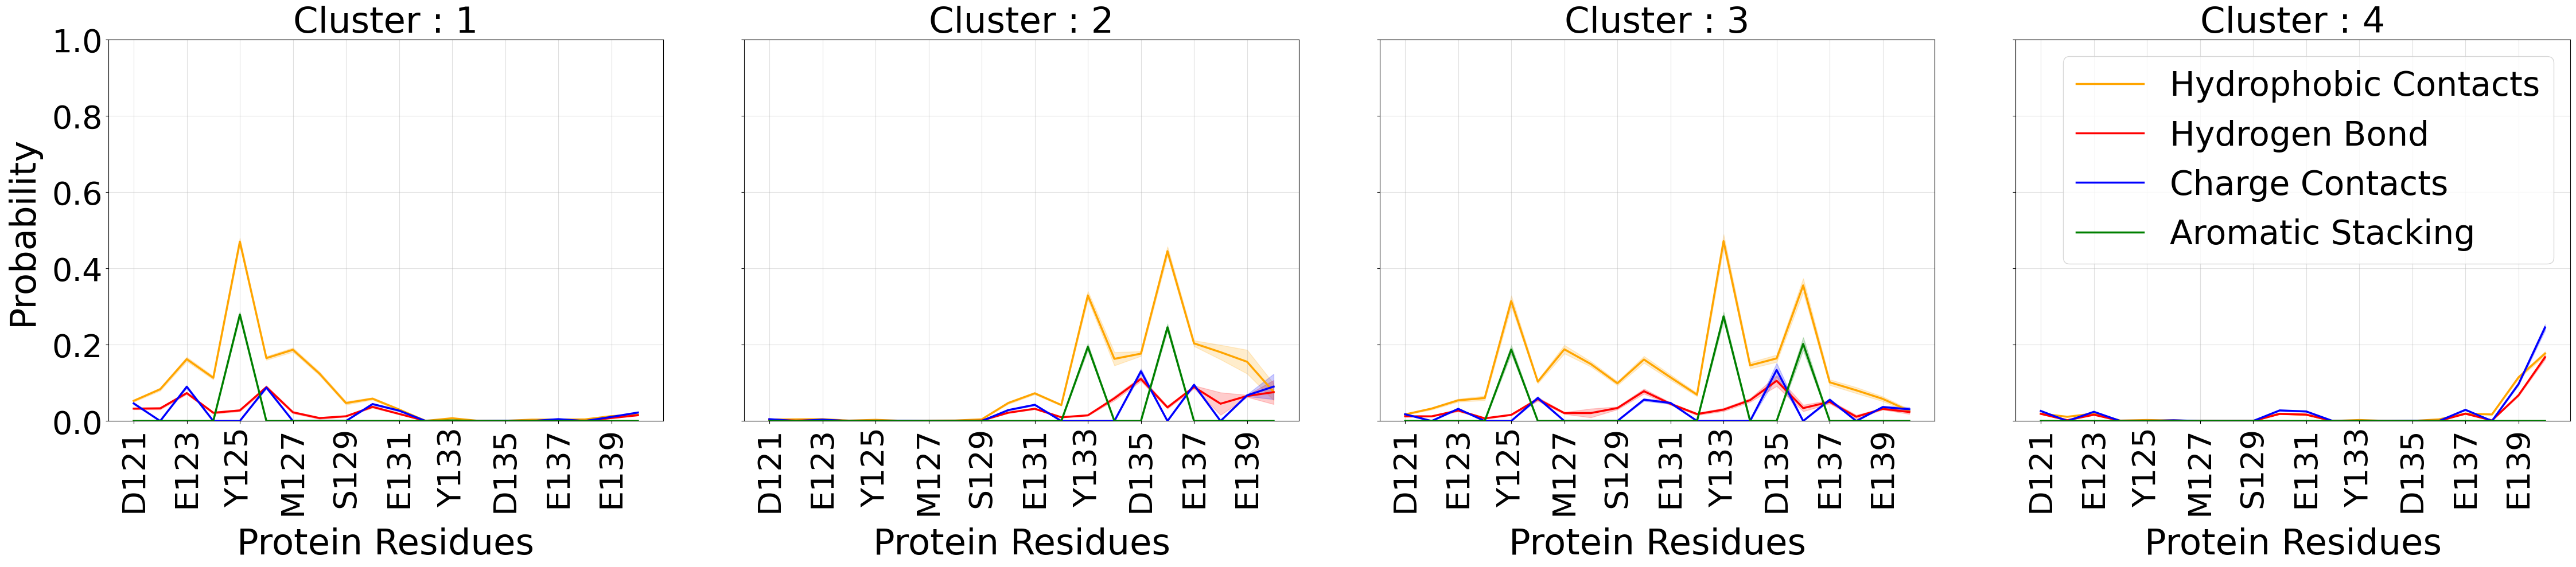

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(45, 10), sharex=True, sharey=True)
#res = np.array([str(trj[0].topology.residue(i)) for i in range(20)])
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')

for i in range(4):
    p = np.unravel_index(i,(4))
    
    ax[p].plot(hydro[i].T[0], hydro[i].T[1], linewidth=2.5, label='Hydrophobic Contacts', color='orange')
    ax[p].fill_between(hydro[i].T[0], hydro[i].T[1]-hydro[i].T[2],
                          hydro[i].T[1]+hydro[i].T[2], alpha=0.2,color='orange')
    
    ax[p].plot(Hbond[i].T[0], Hbond[i].T[1], linewidth=2.5,label='Hydrogen Bond', color='red')
    ax[p].fill_between(Hbond[i].T[0], Hbond[i].T[1]-Hbond[i].T[2],
                          Hbond[i].T[1]+Hbond[i].T[2], alpha=0.2,color='r')
    
    ax[p].plot(charge_[i].T[0], charge_[i].T[1], linewidth=2.5,label='Charge Contacts',c='blue')
    ax[p].fill_between(charge_[i].T[0], charge_[i].T[1]-charge_[i].T[2],
                          charge_[i].T[1]+charge_[i].T[2], alpha=0.2,color='blue')
    
    ax[p].plot(aro_[i].T[0], aro_[i].T[1], linewidth=2.5, color='green', label='Aromatic Stacking')
    ax[p].fill_between(aro_[i].T[0], aro_[i].T[1]-aro_[i].T[2],
                         aro_[i].T[1]+aro_[i].T[2], alpha=0.2,color='green')
    
    ax[p].set_ylim(0,1.0)
    ax[p].set_xticks(range(int(min(Hbond[i][:,0])),int(max(Hbond[i][:,0])+1),2))
    ax[p].set_xticklabels(res_)
    ax[p].tick_params(labelsize=40)
    ax[p].grid(alpha=0.4)
    plt.setp(ax[p].get_xticklabels(), rotation=90)
    
    
    if i == 3:
        ax[p].legend(loc=1,prop={'size': 42})

    a='Cluster : '+str(i+1)
    ax[p].set_title(a,size=45)
    
    #text_=r'$K_{D}$'+' : '+str(round(K[2][i],2))+r'$\pm$'+str(round(K[3][i],2))
    #ax[p].text(120.3, 0.63, text_, fontsize = 26)
    
    ax[0].set_ylabel("Probability", size=45, labelpad=15)
    ax[p].set_xlabel('Protein Residues', size=45, labelpad=15)
        
plt.tight_layout()

In [30]:
np.save("intermol_Hbond_pca_combined_lig.npy", Hbond)
np.save("intermol_charge_pca_combined_lig.npy", charge_)
np.save("intermol_aro_pca_combined_lig.npy", aro_)
np.save("intermol_hydro_pca_combined_lig.npy", hydro)

In [81]:
interactions_all = np.hstack((hydro, Hbond, charge_, aro_))
np.save("intermol_interac_pca_combined_lig.npy", interactions_all)

NameError: name 'hydro' is not defined

fig=plt.figure(figsize=(10,8))

default_x_ticks=range(8)
plt.xticks(range(0,8),fontsize=20, rotation=45, font='Verdana',color='r')
#ax1.set_xticklabels(kd41[:,0])
plt.xlabel('Cluster Number (Lig 47)', fontsize=24,color='r')
plt.plot(range(8),K[2],linestyle='--', marker='o', color='r', lw=2, ms=7)
plt.fill_between(range(8), K[2]-K[3], K[2]+K[3], color='r', alpha=0.2)

#plt.yticks(np.arange(2.5,9,0.5),size=20)
plt.grid(alpha=0.4)
yl=r'$K_{D}$(mM)'
plt.ylabel(yl,size=20)
plt.tight_layout()

plt.tight_layout()


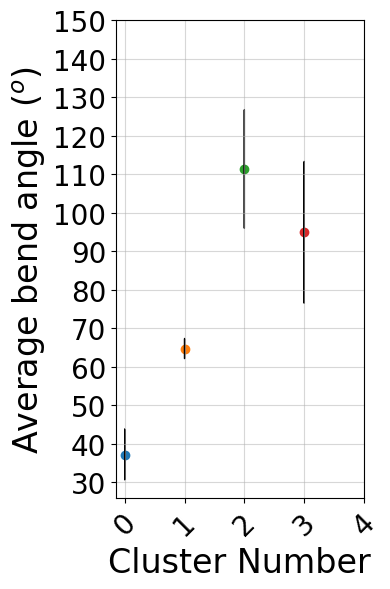

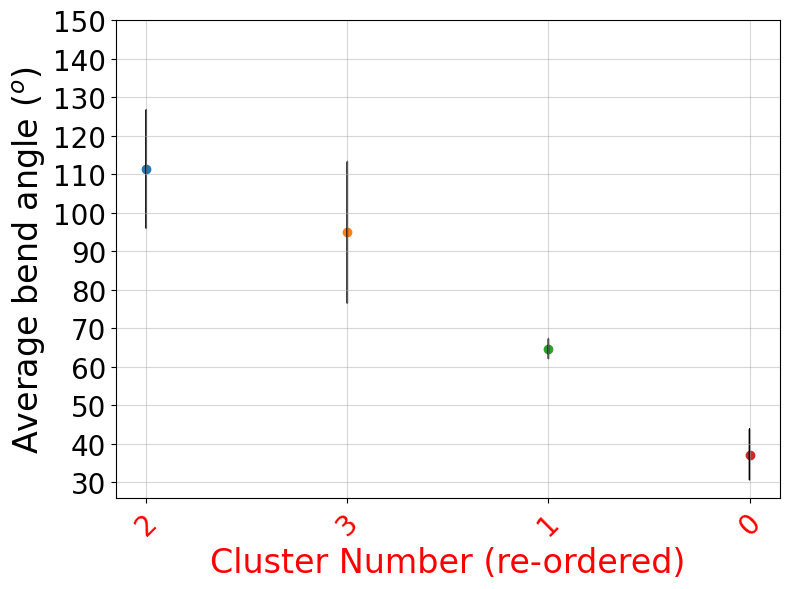

In [37]:
AA=[]
for i in range(len(A)): AA.append([i,np.average(A[i]),np.std(A[i])])
    
AA=np.asarray(AA)
AA_s=np.array(sorted(AA,key=lambda x: x[1], reverse=True))

plt.figure(figsize=(4,6))
for i in range(4):
    
    plt.scatter(AA.T[0][i],AA.T[1][i])
    plt.arrow(AA.T[0][i],(AA.T[1][i]-(AA.T[2][i]/2)),0,AA.T[2][i])
    
plt.xticks(range(0,5),size=20,rotation=45)
plt.yticks(range(30,160,10),size=20)
    
plt.xlabel("Cluster Number",size=24)
plt.ylabel("Average bend angle ($^{o}$)", size=24)
plt.grid(alpha=0.5)
plt.tight_layout()


plt.figure(figsize=(8,6))
for i in range(4):
    
    plt.scatter(i,AA_s.T[1][i])
    plt.arrow(i,(AA_s.T[1][i]-(AA_s.T[2][i]/2)),0,AA_s.T[2][i])

plt.xticks(range(0,4),AA_s.T[0].astype(int),size=20,rotation=45,color='r')
plt.yticks(range(30,160,10),size=20)
    
plt.xlabel("Cluster Number (re-ordered)",size=24, color='r')
plt.ylabel("Average bend angle ($^{o}$)", size=24)
plt.grid(alpha=0.5)
plt.tight_layout()


corr=pearsonr(K[2],AA.T[1])[0]
text_=r'$r^{2}$'
print('r for Kd_bend (Lig 47) :',corr)

m, c = np.polyfit(K[2],AA.T[1],1) 

plt.figure(figsize=(10,8))
plt.scatter(K[2],AA.T[1],marker='s', color='r', label='Lig 47',s=90)

plt.plot(K[2],(m * K[2])+c, lw=2,color='g',label='Fit')

plt.grid(alpha=0.4)

plt.legend(prop={'size' : 18})
plt.ylabel(r"Bend Angle ($^{O}$)",size=25)
plt.xlabel(r'$K_{D}$(mM)',size=25)
plt.tick_params(labelsize=22)

#plt.yticks(np.arange(55,125,10))

#plt.xticks(np.arange(3,6,0.5))


Total_aro=[]
for i in range(len(aro)):
    a=np.sum(aro[i].T[1])
    Total_aro.append(a)
Total_aro=np.array(Total_aro)

fig, ax = plt.subplots(2, 4, figsize=(32, 10), sharex=True, sharey=True)

for i in range(8):
    p, q = np.unravel_index(i,(2, 4))
    
    j=AA_s.T[0][i].astype(int)
    
    ax[p, q].plot(hydro[j].T[0], hydro[j].T[1], linewidth=2.5, label='Hydrophobic Contacts', color='green')
    ax[p,q].fill_between(hydro[j].T[0], hydro[j].T[1]-hydro[j].T[2],
                         hydro[j].T[1]+hydro[j].T[2], alpha=0.2,color='green')
    
    ax[p, q].plot(Hbond[j].T[0], Hbond[j].T[1], linewidth=2.5,label='Hydrogen Bond', color='red')
    ax[p,q].fill_between(Hbond[j].T[0], Hbond[j].T[1]-Hbond[j].T[2],
                         Hbond[j].T[1]+Hbond[j].T[2], alpha=0.2,color='r')
    
    ax[p, q].plot(charge_[j].T[0], charge_[j].T[1], linewidth=2.5,label='Charge Contacts',c='blue')
    ax[p,q].fill_between(charge_[j].T[0], charge_[j].T[1]-charge_[j].T[2],
                         charge_[j].T[1]+charge_[j].T[2], alpha=0.2,color='blue')
    
    ax[p, q].plot(aro_[j].T[0], aro_[j].T[1], linewidth=2.5, color='black', label='Aromatic Stacking')
    ax[p,q].fill_between(aro_[j].T[0], aro_[j].T[1]-aro_[j].T[2],
                         aro_[j].T[1]+aro_[j].T[2], alpha=0.2,color='blue')
    
    ax[p, q].set_ylim(0,0.7)
    ax[p, q].set_xticks(range(int(min(hydro[j][:,0])),int(max(hydro[j][:,0])+2),2))
    ax[p,q].tick_params(labelsize=25)
    ax[p,q].grid(alpha=0.4)
    plt.setp(ax[p,q].get_xticklabels(), rotation=45)
    
    if i == 0:
        ax[p,q].legend(loc=1,prop={'size': 20})

    a='Cluster : '+str(j)
    ax[p,q].set_title(a,size=28)
    
    text_=r'$K_{D}$'+' : '+str(round(K[2][j],2))+r'$\pm$'+str(round(K[3][j],2))
    ax[p,q].text(120.3, 0.63, text_, fontsize = 26)
    text_1=r'$\theta_{avg}$ : '+str(round(AA_s.T[1][i],2))+'$^{o}$'
    ax[p,q].text(120.3, 0.55, text_1, fontsize = 26)
    text_2=r'$Aro_{Total}$ : '+str(round(Total_aro[j],2))
    ax[p,q].text(120.3, 0.47, text_2, fontsize = 26)
    
    if not q : ax[p,q].set_ylabel("Probability", size=30, labelpad=15)
    if p == 5-1 : ax[p,q].set_xlabel('Protein Residues', size=30, labelpad=15)
        
plt.tight_layout()

In [31]:
def contact_map_protein_(trj,cutoff=1.2):
    
    contact_maps = []
    contact_distances = []
    for i in range(0, 20):
        contact_map = []
        contact_distance = []
        for j in range(0, 20):
            if i == j:
                contacts = 0
            else:
                dist = md.compute_contacts(trj, [[i, j]])
                array = np.asarray(dist[0]).astype(float)
                #distance = np.average(array)
                #contact_distance.append(np.average(array))
                #contact = np.where(array < cutoff, 1, 0)
                contacts = np.average(np.where(array < cutoff, 1, 0))
            contact_map.append(contacts)
        contact_maps.append(contact_map)
        #contact_distances.append(contact_distance)

    final_map = np.asarray(contact_maps).astype(float)
    #final_distance = np.asarray(contact_distances).astype(float)
    
    return final_map

In [32]:
!pwd

/data/asn/tica/lig_47/combined


traj_dir='/home/apara/Documents/asn/tica/fasudil/dist/'
pdb='/home/apara/Documents/asn/biorxiv2021-5475823-no-water-glue/last_frame.pdb'

trj_dict={}

for i in range(1,9):
    xtc = traj_dir+"fusadil_cluster8_"+str(i)+'_d4.dcd'

    trj_dict[str(i)] = md.load(xtc, top=pdb, stride=1)
    trj_dict[str(i)].center_coordinates()
    print(trj_dict[str(i)].n_frames)
    
top = trj_dict['1'].topology

#print(trj.n_frames)

#box_len=trj.unitcell_lengths[0][0]

In [33]:
C=[]
for i in range(4):
    c=contact_map_protein_(trj[i])
    
    C.append(c)

In [34]:
np.save("pep_contact_pca_combined_lig.npy", C)

In [35]:
def subplot_snsheat(data, ax=None, cbar=False, cbar_ax=None):
    from numpy import ndarray
    import seaborn as sns
    if type(data) is ndarray:

        if ax is None:
            ax = plt.gca()

        plot = sns.heatmap(data, cmap='Blues', vmin=0,vmax=1.0,ax=ax, cbar=cbar, cbar_ax=None if not cbar else cbar_ax)
        return plot

    else: pass
    
def subplot_imshow(data, xedges, yedges, ax=None):
    
    from numpy import ndarray
    
    if type(data) is ndarray:

        if ax is None:
            ax = plt.gca()
            
        im = ax.imshow(data, interpolation='gaussian', extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
                        cmap='jet', aspect='auto')
        #cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),aspect=10)
        
        return im
    
    else : pass

In [36]:
sequence=  ['ASP121', '', 'GLU123', '', 'TYR125', '', 'MET127', '', 'SER129', '', 'GLU131', '',\
            'TYR133', '', 'ASP135', '', 'GLU137', '', 'GLU139', 'ALA140']

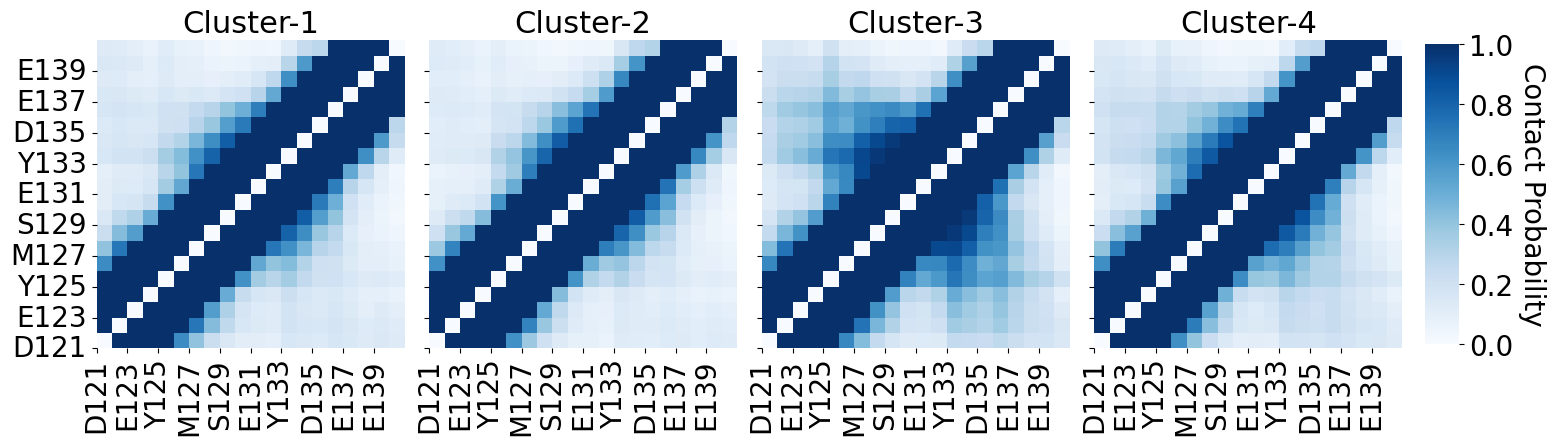

In [37]:
ncol = 4
nrow = 1
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(17, 4))
cbar_ax = fig.add_axes([.91, .12, .02, .75])

for i in range(4):
    #contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    contact_map = C[i]
    p = np.unravel_index(i,(5))
    cb = i==1
    subplot_snsheat(contact_map, ax=ax[p], cbar=cb, cbar_ax=cbar_ax)
    ax[p].set_xticks(range(0, 20,2), res_, rotation=90, size=20)
    ax[p].set_yticks(range(0, 20,2), res_, rotation=0, size=20)
    ax[p].invert_yaxis()
    ax[p].set_aspect('equal', 'box')
    ax[p].set_title('Cluster-'+str(i+1),size=22)
cbar_ax.tick_params(labelsize=20)
cbar_ax.set_ylabel('Contact Probability', rotation=270, fontsize = 20, labelpad=24)
    
plt.subplots_adjust(wspace=0.04, hspace=0)

In [38]:
def contact_map_ligand_(trj,ligand_res_index,cutoff=0.6):

    contact_maps = []
    for i in range(0, 20):
        # print(i)
        contact_map = []
        for j in range(0, 20):
            dist1 = md.compute_contacts(trj, [[i, ligand_res_index]], scheme='closest-heavy')
            dist2 = md.compute_contacts(trj, [[j, ligand_res_index]], scheme='closest-heavy')
            array1 = np.asarray(dist1[0]).astype(float)
            array2 = np.asarray(dist2[0]).astype(float)
            contact1 = np.where(array1 < cutoff, 1, 0)
            contact2 = np.where(array2 < cutoff, 1, 0)
            sum = contact1 + contact2
            #contact = np.where(sum == 2, 1, 0)
            contacts = np.average(np.where(sum == 2, 1, 0))
            contact_map.append(contacts)
        contact_maps.append(contact_map)
        
    return np.asarray(contact_maps).astype(float)

In [39]:
C_=[]
for i in range(4):
    c_=contact_map_ligand_(trj[i],21)
    
    C_.append(c_)

In [40]:
np.save("dual_contact_pca_combined_lig.npy", C_)

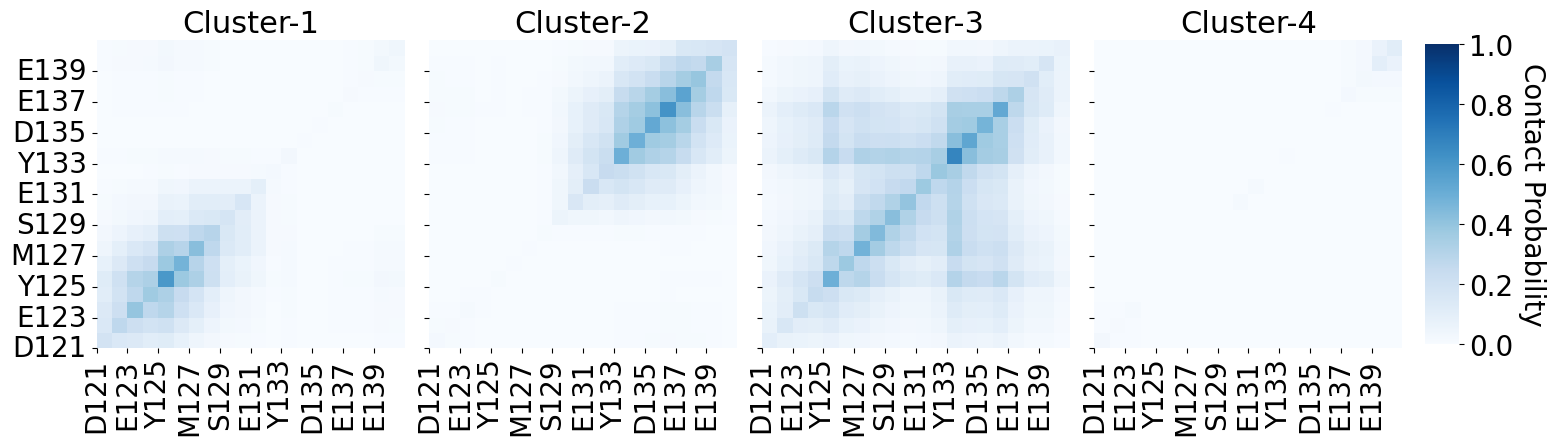

In [41]:
ncol = 4
nrow = 1
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(17, 4))
cbar_ax = fig.add_axes([.91, .12, .02, .75])

for i in range(4):
    #contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    contact_map = C_[i]
    p = np.unravel_index(i,(5))
    cb = i==1
    subplot_snsheat(contact_map, ax=ax[p], cbar=cb, cbar_ax=cbar_ax)
    ax[p].set_xticks(range(0, 20,2), res_, rotation=90, size=20)
    ax[p].set_yticks(range(0, 20,2), res_, rotation=0, size=20)
    ax[p].invert_yaxis()
    ax[p].set_aspect('equal', 'box')
    ax[p].set_title('Cluster-'+str(i+1),size=22)
cbar_ax.tick_params(labelsize=20)
cbar_ax.set_ylabel('Contact Probability', rotation=270, fontsize = 20, labelpad=24)
    
plt.subplots_adjust(wspace=0.04, hspace=0)

In [42]:
paul_mi = np.loadtxt('/data/asn/Fasudil_MI_stride1/s1/Lig47.TotaInt.s1.reorder.417.dat')

In [43]:
frames_cl

[array([      0,       1,       2, ..., 1100698, 1100700, 1100701]),
 array([    124,     159,     188, ..., 1100886, 1100887, 1100888]),
 array([      3,       4,       5, ..., 1100823, 1100824, 1100870]),
 array([    112,     113,     114, ..., 1100726, 1100727, 1100728])]

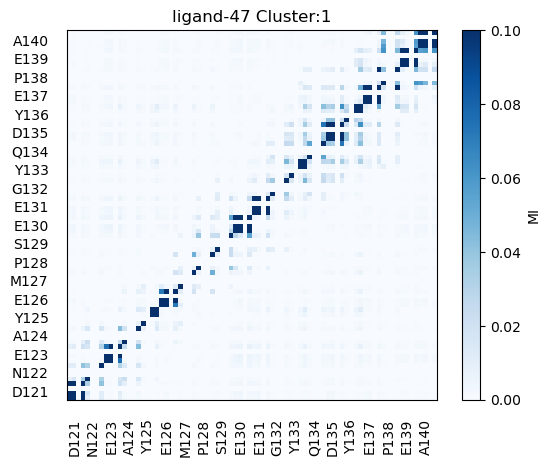

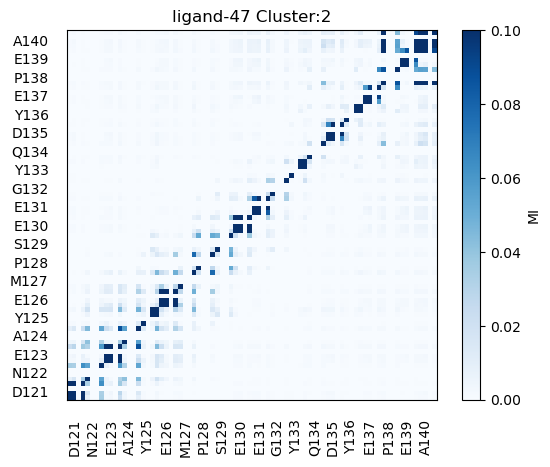

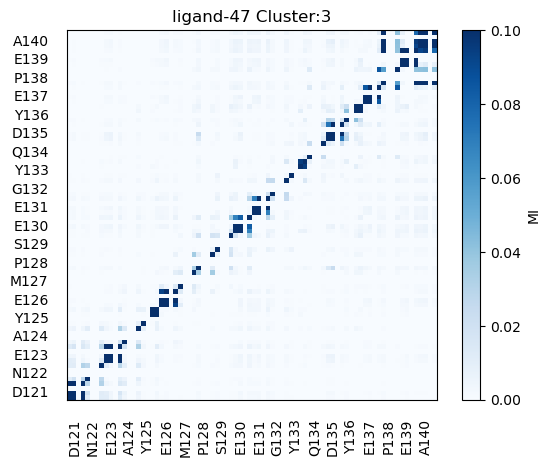

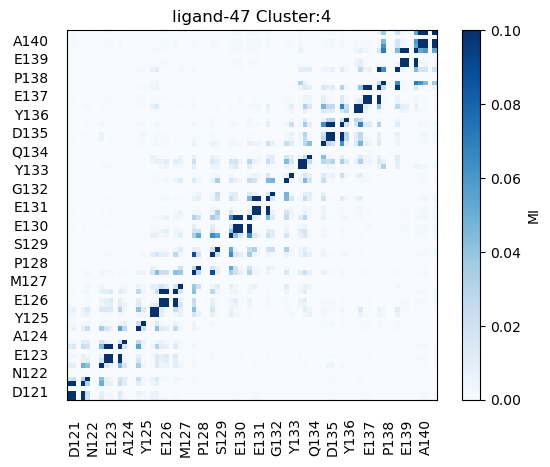

In [44]:
#TotalInt_=np.loadtxt("Fasudil.TotaInt.s1.reorder.417.dat")
for index,event in enumerate(frames_cl):
    TotalInt = paul_mi[event]
    frames=float(len(TotalInt[:,0]))
    features=len(TotalInt[0])
    probx1=TotalInt.sum(axis=0)/frames
    probx0=1-probx1
    probxy11=np.zeros((features,features))
    probxy00=np.zeros((features,features))
    probxy01=np.zeros((features,features))
    probxy10=np.zeros((features,features))

    for i in range(0,features):
        a=np.where(TotalInt[:,i]==(1))
        b=np.where(TotalInt[:,i]==(0))
        for j in range(0,features):
            c=np.where(TotalInt[:,j]==(1))
            d=np.where(TotalInt[:,j]==(0))
            probxy11[i][j]=len(np.intersect1d(a,c))/frames
            probxy00[i][j]=len(np.intersect1d(b,d))/frames
            probxy01[i][j]=len(np.intersect1d(b,c))/frames
            probxy10[i][j]=len(np.intersect1d(a,d))/frames

    MI=np.zeros((features,features))
    for i in range(0,features):
        px1=probx1[i]
        px0=probx0[i]
        for j in range(0,features):
            py1=probx1[j]
            py0=probx0[j]
            pxy11=probxy11[i][j]
            pxy00=probxy00[i][j]
            pxy01=probxy01[i][j]
            pxy10=probxy10[i][j]
            MI11=0
            MI10=0
            MI01=0
            MI00=0
            H11=0
            H10=0
            H01=0
            H00=0
            if (px1!=0 and py1!=0 and pxy11!= 0):
                MI11=pxy11*np.log2(pxy11/(px1*py1))
                H11=pxy11*np.log2(pxy11)
            if (px0!=0 and py0!=0 and pxy00!= 0):
                MI00=pxy00*np.log2(pxy00/(px0*py0))
                H00=pxy00*np.log2(pxy00)
            if (px0!=0 and py1!=0 and pxy01!= 0):
                MI01=pxy01*np.log2(pxy01/(px0*py1))
                H01=pxy01*np.log2(pxy01)
            if (px1!=0 and py0!=0 and pxy10!= 0):
                MI10=pxy10*np.log2(pxy10/(px1*py0))
                H10=pxy10*np.log2(pxy10)
            H=H11+H00+H01+H10
            if(H!=0):
                MI[i][j]=(MI11+MI00+MI01+MI10)/(-H)

        #print i,j, MI[i][j],pxy11,pxy00    
    #MI[isnan(MI)]=0

    np.save(f'lig47_pca.MI.{index+1}.npy',MI,'%f')

    #plt.clf()
    #plt.title('Pythonspot.com heatmap example')
    #plt.xlabel(r'r_OF ($\AA$)')
    #plt.ylabel(r'r_OH ($\AA$)')
    plt.figure()
    extent = (0, 80, 0, 80)
    plt.imshow(np.flipud(MI), extent=extent, interpolation='None', aspect=1.0,cmap='Blues')
    plt.yticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),va='bottom')
    plt.xticks([0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'),rotation=90,ha='left')
    plt.tick_params(axis='x', color='white',labelcolor='black',length=10,top='on')
    plt.tick_params(axis='y', color='white',labelcolor='black',length=10,right='on')
    plt.clim(vmin=0,vmax=0.10)
    plt.colorbar(label = 'MI')
    plt.title(f"ligand-47 Cluster:{index+1}")
    #plt.show()
    #plt.savefig(f'Lig47.MI.{index+1}.png', format='png', dip=1000)
    #.figure()

<Figure size 640x480 with 0 Axes>

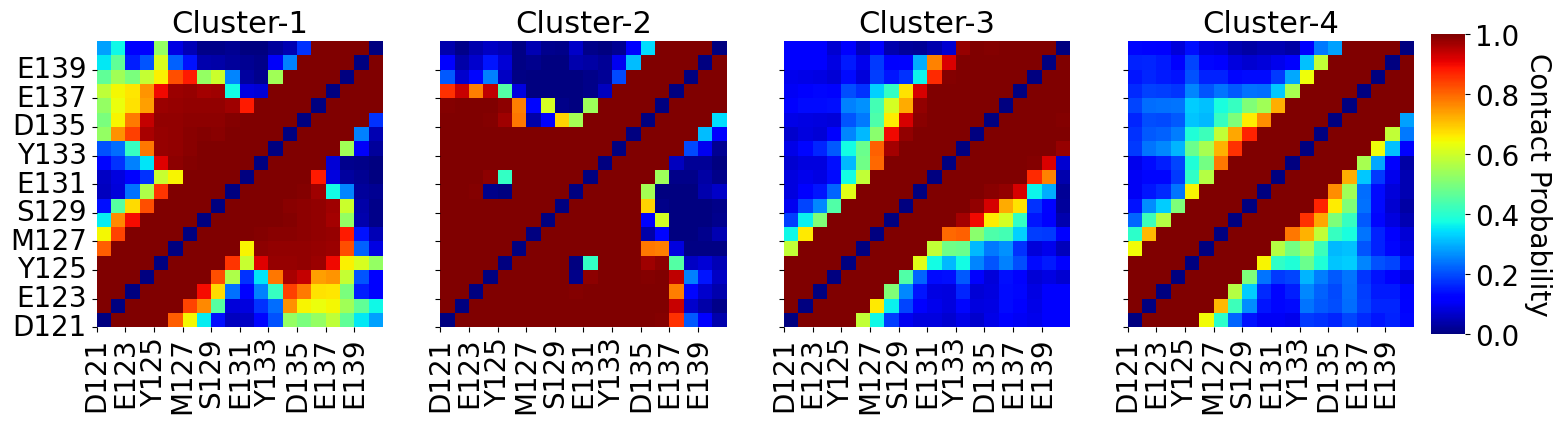

<Figure size 640x480 with 0 Axes>

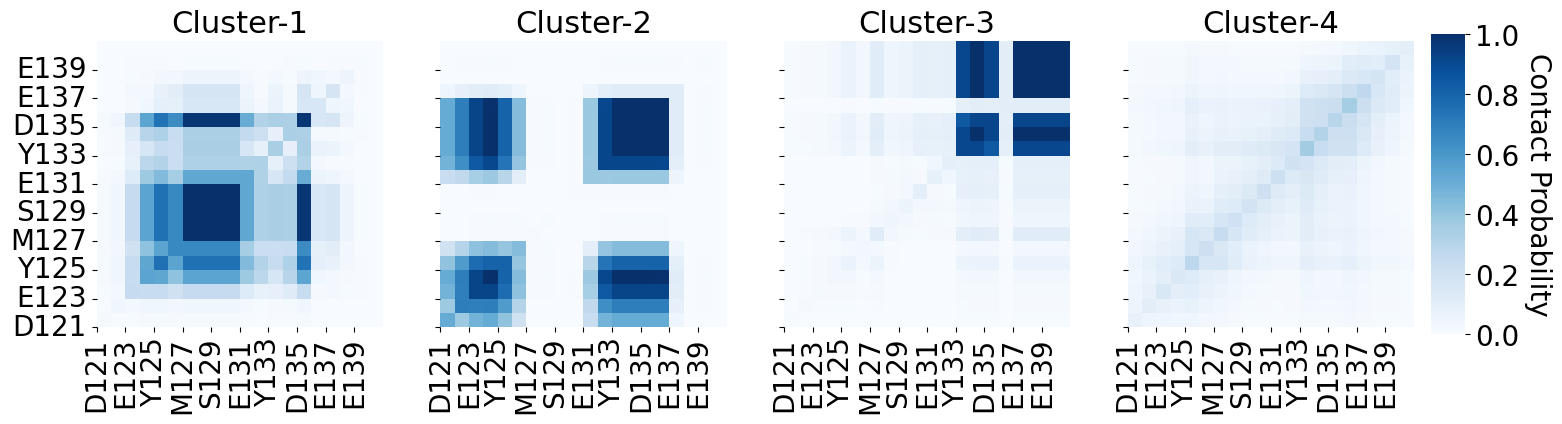

<Figure size 640x480 with 0 Axes>

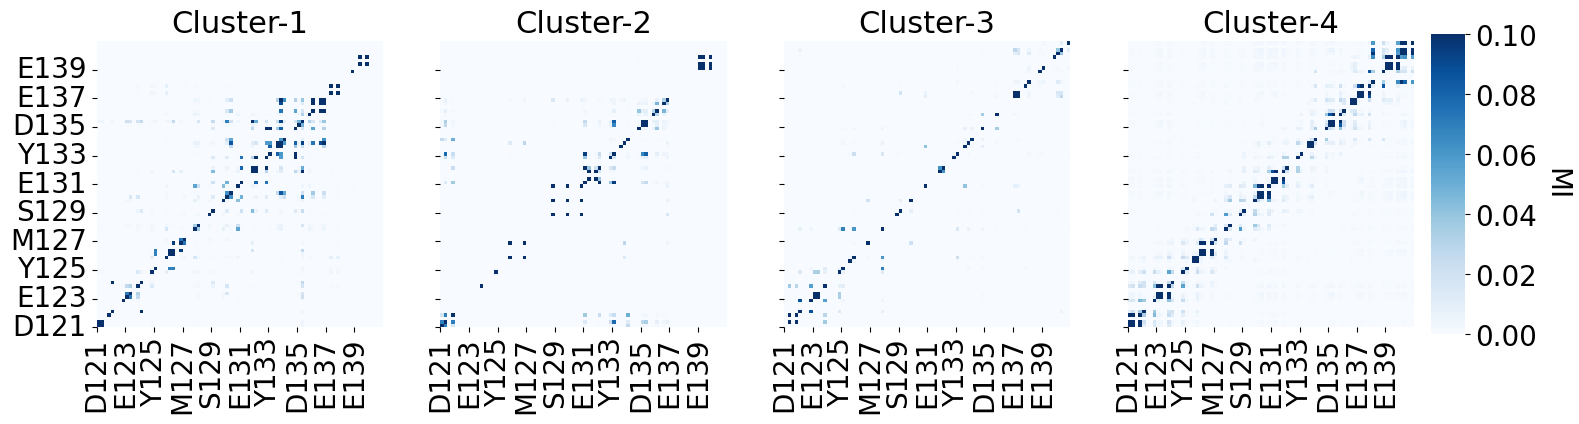

In [73]:
mi=[]
for i in range (1,5):
    mi.append(np.load("/data/asn/tica/lig_47/combined/lig47.MI."+str(i)+'.npy'))
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')
#title = 'Mutual Information \n Charge-contacts - Intermolecular-distances'
#xlabel = 'Intermolecular-distances'
#ylabel = 'Charge-contacts'
plt.subplots_adjust(wspace=0.01, hspace=1)
ncol = 4
nrow = 1
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(17, 4))
cbar_ax = fig.add_axes([.91, .12, .02, .75])
for i in range(4):
    #contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    contact_map = mi[i]
    p = np.unravel_index(i,(5))
    cb = i==1
    plot = sns.heatmap(contact_map, ax=ax[p], vmin = 0, vmax= 0.1, cmap = "Blues",  cbar=cb, cbar_ax=cbar_ax)
                  #xticklabels = res, yticklabels = charge_res)
    #cbar = ax.collections[0].colorbar
    #cbar.set_label(label = "MI",size = 15)
    #cbar.ax.tick_params(labelsize=15)
    ax[p].invert_yaxis()
    ax[p].tick_params(axis = 'x', rotation = 90)
    ax[p].set_title('Cluster-'+str(i+1),size=22)
    ax[p].set_aspect('equal', 'box')
    ax[p].set_xticks(range(0, 80,8), res_, rotation=90, size=20)
    ax[p].set_yticks(range(0, 80,8), res_, rotation=0, size=20)
    #ax[p].set_xlabel(xlabel, size = 15)
    #ax[p].set_ylabel(ylabel, size = 15)
cbar_ax.tick_params(labelsize=20)
cbar_ax.set_ylabel('MI', rotation=270, fontsize = 20, labelpad=24)
plt.savefig(f'Lig47.MI.lig47.png', bbox_inches="tight")